# Figure showcasing the posterior

In [1]:
import os, glob
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch
from haloflow import data as D
from haloflow import util as U

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [5]:
qphis0 = U.read_best_ndes('msmh.mags.maf', device=device)
qphis1 = U.read_best_ndes('msmh.mags_morph.maf', device=device)
# qphis2 = U.read_best_ndes('msmh.mags_morph_satlum_all.maf', device=device)
# qphis3 = U.read_best_ndes('msmh.mags_morph_satlum_all_rich_all.maf', device=device)
qphis2 = U.read_best_ndes('msmh.v1.mags_morph_satlum_mrlim.maf', device=device)
qphis3 = U.read_best_ndes('msmh.v1.mags_morph_satlum_mrliml_rich_mrlim.maf', device=device)

1083 models trained
[138, 529, 86, 803, 942]
1669 models trained
[49, 1523, 1159, 1415, 690]
495 models trained
[182, 443, 427, 403, 297]
506 models trained
[424, 39, 136, 402, 98]


In [6]:
y0, x0 = D.get_subhalos('test', 'mags', snapshot=91)
y1, x1 = D.get_subhalos('test', 'mags_morph', snapshot=91)
# y2, x2 = D.get_subhalos('test', 'mags_morph_satlum_all', snapshot=91)
# y3, x3 = D.get_subhalos('test', 'mags_morph_satlum_all_rich_all', snapshot=91)
y2, x2 = D.get_subhalos('test', 'mags_morph_satlum_mrlim', snapshot=91)
y3, x3 = D.get_subhalos('test', 'mags_morph_satlum_mrlim_rich_mrlim', snapshot=91)

In [7]:
n_sample = 10000

ranks0, ranks1, ranks2, ranks3 = [], [], [], []
y_nde0, y_nde1, y_nde2, y_nde3 = [], [], [], []

for i in trange(y0.shape[0]): 
    for qphis, ranks, y_nde, xs, ys in zip([qphis0, qphis1, qphis2, qphis3], 
                                           [ranks0, ranks1, ranks2, ranks3], 
                                           [y_nde0, y_nde1, y_nde2, y_nde3], 
                                           [x0, x1, x2, x3], [y0, y1, y2, y3]): 
        y_samp = []
        for qphi in qphis: 
            _samp = qphi.sample((int(n_sample/len(qphis0)),),
                               x=torch.tensor(xs[i], dtype=torch.float32).to(device), 
                               show_progress_bars=False)
            y_samp.append(_samp.detach().cpu().numpy())
        y_nde.append(np.concatenate(np.array(y_samp), axis=0))        
    
        _ranks = []
        for i_dim in range(y_nde[-1].shape[1]): 
            _ranks.append(np.mean(y_nde[-1][:,i_dim].flatten() < ys[i, i_dim]))
        ranks.append(_ranks)
    
ranks0 = np.array(ranks0)
ranks1 = np.array(ranks1)
ranks2 = np.array(ranks2)
ranks3 = np.array(ranks3)

y_nde0 = np.array(y_nde0)
y_nde1 = np.array(y_nde1)
y_nde2 = np.array(y_nde2)
y_nde3 = np.array(y_nde3)

  0%|          | 0/500 [00:00<?, ?it/s]

In [31]:
i_field = 439 # np.random.choice(np.arange(x3.shape[0])[x3[:,-1] == 0])
i_group = 18 # np.random.choice(np.arange(x3.shape[0])[x3[:,-1] > 5])

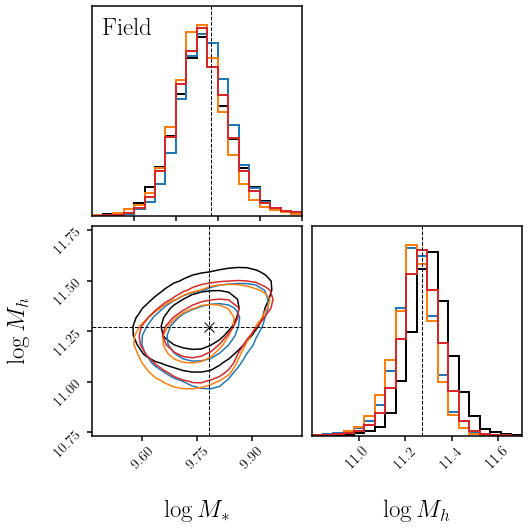

In [35]:
fig = plt.figure(figsize=(8,8))

rng = [(9.5, 10.0), (10.8, 11.7)]
_ = DFM.corner(y_nde0[i_field], color='k', range=rng, 
                 hist_kwargs={'density': True, 'linewidth': 2},
                 levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde1[i_field], color='C0', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde2[i_field], color='C1', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde3[i_field], color='C3', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], 
               labels=[r'$\log M_*$', r'$\log M_h$'], label_kwargs={'fontsize': 25},
                plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
DFM.overplot_points(fig, [y0[i_field]], color='k', marker='x', markersize=10)
DFM.overplot_lines(fig, y0[i_field], color='k', linestyle='--', linewidth=1)

axes = np.array(fig.axes).reshape(2,2)


sub = axes[0,0]
sub.text(0.05, 0.95, 'Field', transform=sub.transAxes, ha='left', va='top', fontsize=25)

sub = axes[1,1]
sub.set_xlim(rng[1])

sub = axes[0,0]
sub.set_xlim(rng[0])
fig.savefig('figs/posterior_field.pdf', bbox_inches='tight')

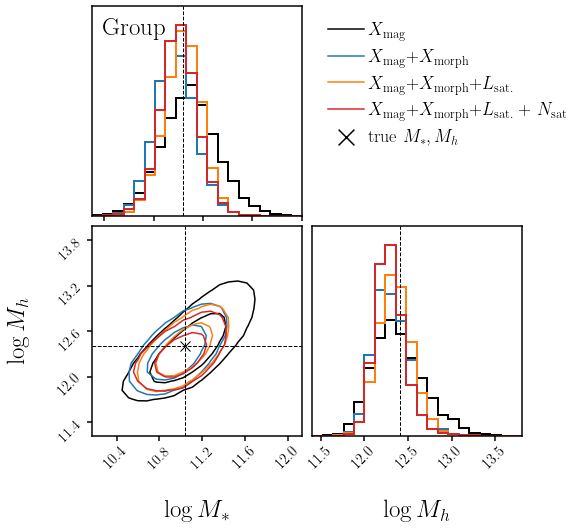

In [33]:
fig = plt.figure(figsize=(8,8))

rng = [(10.3, 12.0), (11.4, 13.8)]
_ = DFM.corner(y_nde0[i_group], color='k', range=rng, 
                 hist_kwargs={'density': True, 'linewidth': 2},
                 levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde1[i_group], color='C0', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde2[i_group], color='C1', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde3[i_group], color='C3', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], 
               labels=[r'$\log M_*$', r'$\log M_h$'], label_kwargs={'fontsize': 25},
                plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
DFM.overplot_points(fig, [y0[i_group]], color='k', marker='x', markersize=10)
DFM.overplot_lines(fig, y0[i_group], color='k', linestyle='--', linewidth=1)

axes = np.array(fig.axes).reshape(2,2)

sub = axes[0,0]
sub.text(0.05, 0.95, 'Group', transform=sub.transAxes, ha='left', va='top', fontsize=25)

sub = axes[0,1]
sub.plot([], [], color='k', label=r'$X_{\rm mag}$')
sub.plot([], [], color='C0', label=r'$X_{\rm mag}$+$X_{\rm morph}$')
sub.plot([], [], color='C1', label=r'$X_{\rm mag}$+$X_{\rm morph}$'+r'+$L_{\rm sat.}$')
sub.plot([], [], color='C3', label=r'$X_{\rm mag}$+$X_{\rm morph}$'+r'+$L_{\rm sat.}$ + $N_{\rm sat}$')
sub.scatter([], [], color='k', marker='x', s=10, label='true $M_*, M_h$')
sub.legend(loc='upper left', handletextpad=0.2, markerscale=5, fontsize=18)

sub = axes[1,1]
sub.set_xlim(rng[1])


sub = axes[0,0]
sub.set_xlim(rng[0])
fig.savefig('figs/posterior_group.pdf', bbox_inches='tight')

https://arxiv.org/pdf/0903.4682.pdf

In [95]:
def msmh_moster(logMh, A, beta, gamma, M1): 
    Mh = 10**logMh
    return 2. * A * ((Mh/M1)**-beta + (Mh/M1)**gamma)**-1

def mh_moster(logMs, A, beta, gamma, M1):
    mh_arr = np.linspace(10., 15., 201)
    ms_arr = 10**mh_arr * msmh_moster(mh_arr, A, beta, gamma, M1)
    return np.interp(logMs, np.log10(ms_arr), mh_arr)
    
def moster_posterior(): 
    A = 0.02820 + 0.00057*np.random.normal()
    beta = 1.057 + 0.05*np.random.normal()
    gamma = 0.556 + 0.07*np.random.normal()
    M1 = 10**(11.884 + 0.0265*np.random.normal())
    return A, beta, gamma, M1

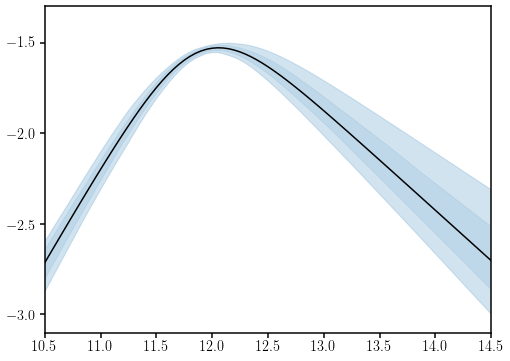

In [71]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

logMhs = np.linspace(10, 15, 101)


msmhs = []
for i in range(100): 
    theta = moster_posterior()
    msmhs.append(np.log10(msmh_moster(logMhs, *theta)))
sub.fill_between(logMhs, np.quantile(msmhs, 0.16, axis=0), np.quantile(msmhs, 0.84, axis=0), color='C0', alpha=0.1)
sub.fill_between(logMhs, np.quantile(msmhs, 0.025, axis=0), np.quantile(msmhs, 0.975, axis=0), color='C0', alpha=0.2)
sub.plot(logMhs, np.log10(msmh_moster(logMhs, 0.02820, 1.057, 0.556, 10**11.884)), c='k')
sub.set_xlim(10.5, 14.5)
sub.set_ylim(-3.1, -1.3)
sub.set_yticks([-3.0, -2.5, -2., -1.5])

In [100]:
mh_straw = []
for ms in y_nde0[i_group,:,0]:
    theta = moster_posterior()
    mh_straw.append(mh_moster(ms, *theta))
    
mcmc_straw = np.array([y_nde0[i_group,:,0], np.array(mh_straw)]).T

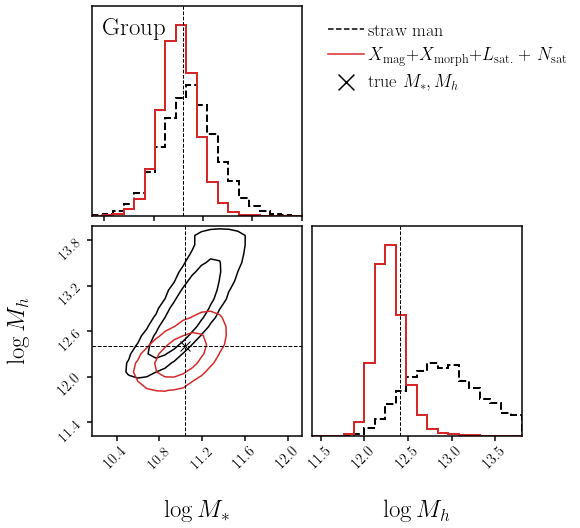

In [104]:
fig = plt.figure(figsize=(8,8))

rng = [(10.3, 12.0), (11.4, 13.8)]
_ = DFM.corner(mcmc_straw, color='k', range=rng, 
                 hist_kwargs={'density': True, 'linewidth': 2, 'linestyle':'--'},
                 levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde3[i_group], color='C3', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], 
               labels=[r'$\log M_*$', r'$\log M_h$'], label_kwargs={'fontsize': 25},
                plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
DFM.overplot_points(fig, [y0[i_group]], color='k', marker='x', markersize=10)
DFM.overplot_lines(fig, y0[i_group], color='k', linestyle='--', linewidth=1)

axes = np.array(fig.axes).reshape(2,2)

sub = axes[0,0]
sub.text(0.05, 0.95, 'Group', transform=sub.transAxes, ha='left', va='top', fontsize=25)

sub = axes[0,1]
sub.plot([], [], color='k', ls='--', label=r'straw man')
sub.plot([], [], color='C3', label=r'$X_{\rm mag}$+$X_{\rm morph}$'+r'+$L_{\rm sat.}$ + $N_{\rm sat}$')
sub.scatter([], [], color='k', marker='x', s=10, label='true $M_*, M_h$')
sub.legend(loc='upper left', handletextpad=0.2, markerscale=5, fontsize=18)

sub = axes[1,1]
sub.set_xlim(rng[1])


sub = axes[0,0]
sub.set_xlim(rng[0])
fig.savefig('figs/posterior_group_straw.pdf', bbox_inches='tight')

(9.5, 12.0)

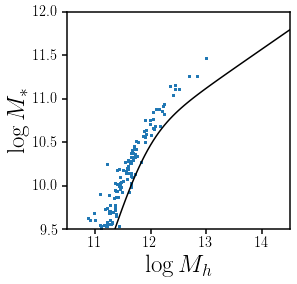

In [112]:
fig = plt.figure(figsize=(4,4))
sub = fig.add_subplot(111)

logMhs = np.linspace(10, 15, 101)

sub.plot(logMhs, logMhs + np.log10(msmh_moster(logMhs, 0.02820, 1.057, 0.556, 10**11.884)), c='k')
sub.scatter(y0[:,1], y0[:,0], s=4)
sub.set_xlabel(r'$\log M_h$', fontsize=25)
sub.set_xlim(10.5, 14.5)
sub.set_ylabel(r'$\log M_*$', fontsize=25)
sub.set_ylim(9.5, 12.)